# FALQON (Feedback-Based Quantum Optimization)

## Bibliografía

[Tutorial FALQON](https://pennylane.ai/qml/demos/tutorial_falqon): Explicación teórica + Implementación de Problema del Maximum Clique (sí usado en este cuaderno al final)

[FALQON](https://arxiv.org/pdf/2103.08619): Paper original del algoritmo FALQON

[FALQON-C](https://arxiv.org/pdf/2406.08169): Paper original del algoritmo FALQON-C

[Ket-G: Hamiltoniano](https://www.youtube.com/watch?v=OXthrvvLhDw): Explicación teórica

In [ ]:
# INDICAR SI ESTAMOS EN COLAB O NO (Jupyter por ejemplo)
colab = False 
if colab:
    !pip install pennylane

In [2]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx

Se trata de un algoritmo cuántico para resolver problemas de **optimización combinatoria**. A diferencia del *QAOA* o del *VQE,* éste utiliza un enfoque únicamente **cuántico** para encontrar soluciones aproximadas a problemas complejos no resolubles en tiempo lineal, sino exponencial (problemas NP). Para ello, construiremos un *circuito cuántico* con unos hiperparámetros adecuados.

Debido a que el enfoque es únicamente cuántico, no cae dentro de la familia de algoritmos *VQA,* aunque se podría considerar cercano al *QAOA.*

Se recomienda estudiar el algoritmo VQE o el apartado 0 del QAOA para entender la base común de este algoritmo con los otros dos.

## 1. Idea del algoritmo

Siguiendo el hilo introducido con el algoritmo QAOA, una estrategia común para resolver un problema de optimización combinatoria con la computación cuántica es codificar la solución del problema como el **estado de mínima energía** de un *Hamiltoniano de coste* $H_c.$ La clave de todo es diseñar un procedimiento que, partiendo de un estado inicial, nos haga llegar al de mínima energía.

Vamos a considerar un **sistema cuántico** gobernado por la *ecuación de Schrödinger*:

$$
iℏ \frac{d}{dt} |\psi (t) \rangle = H(t) |\psi (t) \rangle
$$

donde $ℏ = 1$ y el Hamiltoniano tiene la forma $H = H_c + \beta(t) H_d.$ $H_c$ se corresponde con el **Hamiltoniano de coste** explicado en el algoritmo QAOA, y que está relacionado con la **función objetivo**. Por otro lado, $H_d$ se corresponde con el *Hamiltoniano de mezcla* del QAOA (de hecho, se construye de la misma forma), pero aquí le llamaremos **Hamiltoniano de conducción** (con "d" de "driver"); junto con $\beta (t)$ (una función que podemos escoger), forman el segundo sumando, el cual determina **cómo evoluciona el sistema** con el tiempo.



Como queremos llegar al estado de mínima energía de $H_c$, suena razonable crear un procedimiento tal que el **valor esperado de la energía** asociado $\langle H_c \rangle_t$ *decrezca con el tiempo*, es decir, que su derivada sea negativa:

$$\frac{d}{dt} \langle H_c\rangle_t \leq 0.$$

Recurriendo a la (otra) *ecuación de Schrödinger* desarrollamos $\langle H_c \rangle_t$:

$$\frac{d}{dt} \langle H_c\rangle_t = \frac{d}{dt} \langle \psi(t)|H_c|\psi(t)\rangle = i \beta(t)\langle [H_d, H_c] \rangle_t \leq 0.$$

Y si escogemos $\beta(t) = -\langle i[H_d, H_c] \rangle_t,$ nos damos cuenta de que

$$\frac{d}{dt} \langle H_c\rangle_t = -|\langle i[H_d, H_c] \rangle_t|^2 \leq 0,$$

¡por lo que $\langle H_c \rangle$ seguro que decrece!

Entonces, si hacemos evolucionar un estado inicial cualquiera $|\psi_0\rangle$ (al cual se le pone en superposición con *puertas de Hadamard* para alcanzar el estado $| +  \rangle^{\otimes  n}$) bajo el operador de evolución temporal $U$ correspondiente a $H$ (que cuenta con $H_c$):

$$U(T) = \mathcal{T} e ^{\Big[-i \displaystyle\int_{0}^{T} H(t) \ dt \Big]} \approx \mathcal{T} e ^{\Big[-i \displaystyle\sum_{k = 0}^{T/\Delta t} H( k \Delta t) \Delta t\Big]},$$

donde $\mathcal{T}$ es el *operador de ordenación temporal* y $\Delta t$ *es el paso temporal,* entonces el valor esperado de la energía **estrictamente descenderá** para un valor suficiente de $T$ y para un valor de $\Delta t$ suficientemente pequeño.

Pero claro, tenemos el mismo problema que en el QAOA: implementar un circuito cuántico que hace la exponencial de un Hamiltoniano compuesto de muchos términos que no conmutan entre sí (es decir, $H = H_1 + ... + H_n$) no es fácil. Por ello, se recurre a la **descomposición de Trotter-Suzuki**, la cual establece que:

$$
e^{A+B} \approx (e^{A/n}e^{B/n})^n
$$

Esto nos sirve para implementar un operador unitario de evolución en el tiempo *aproximado* (si $\Delta t$ es suficientemente pequeño):


$$U(T) \approx \mathcal{T} e^{\Big[ -i \displaystyle\sum_{k = 0}^{T/\Delta t} H( k \Delta t) \Delta t \Big]} \approx
e^{-i\beta_n H_d \Delta t} e^{-iH_c \Delta t} \cdots e^{-i\beta_1 H_d \Delta t} e^{-iH_c \Delta t} = U_d(\beta_n) U_c \cdots U_d(\beta_1) U_c,$$

donde $n = T/\Delta t$ y $\beta_k = \beta(k\Delta t).$ Por lo que $| \Psi _n \rangle = U(T=n) | \Psi _0 \rangle = U_d(\beta_n) U_c \cdots U_d(\beta_1) U_c | \Psi _0 \rangle $.

Observando la última fórmula, para cada capa de evolución temporal, necesitamos el valor $\beta_k$. Sin embargo, éste *depende del estado del sistema* en el momento $k$. Recuerda que:

$$\beta_k = - \langle \psi_k | i [H_d, H_c] | \psi_k \rangle.$$

Entonces definiendo $A:= i\langle [H_d, H_c] \rangle_t,$ la estrategia que vamos a seguir es ir calculando los valores $\beta_k$ **recursivamente** al hallar el valor de $A(t)$ en el *momento anterior*. En consecuencia:

$$\beta_{k+1} = -A_k = -\langle \psi_k | i [H_d, H_c] | \psi_k \rangle.$$

De hecho, el hecho de hallar $\beta_k$ recursivamente hace que este algoritmo **no necesite la ayuda de un optimizador clásico**, lo cual presenta una clara ventaja frente a otros algoritmos similares.

Un apunte desde el punto de vista físico: en los intervalos de tiempo en los que se aplica $H_c$, $\frac{d}{dt} \langle H_c \rangle (t) = 0$; es decir, que a pesar de que su valor no cambia, los vectores/estados propios de de $H_c$ sí que acumulan fases en este intervalo temporal, los cuales impactan la dinámica resultante. Es decir, esto se debe a que $H_c$​ conmuta consigo mismo, y por ello la evolución bajo $H_c$​ solo introduce fases globales o relativas en los estados propios (eigenestados) (la medida de energía no cambia, pero sí puede cambiar la interferencia entre componentes).


Por otro lado, en los intervalos temporales en los que se aplica $H_d$, recuperamos el mismo resultado que $\frac{d}{dt} \langle H_c \rangle$. En consecuencia, podemos asegurar que la ecuación de la derivada negativa se cumpla usando la misma ley de retroalimentación, dada por $\beta_{k+1} = -A_k.$

Esto lleva a que el algoritmo FALQON sea un *proceso recursivo*. En el paso $k,$ hacemos las siguientes 3 instrucciones:

1. Preparar el estado
    $|\psi_k\rangle = U_d(\beta_k) U_c \cdots U_d(\beta_1) U_c|\psi_0\rangle.$
2. Medir el valor esperado
    $A_k = \langle \psi_k | i [H_d, H_c] | \psi_k \rangle.$
3. Establecer
    $\beta_{k+1} = -A_k.$

Repetimos esto para todo $k$ de $1$ a $n,$ donde $n$ es un hiperparámetro. En el paso final evaluamos $\langle H_c \rangle,$ el cual nos da una aproximación del valor del estado de mínima energía de $H_c.$

### 1.1 Hamiltoniano de Coste
El primer Hamiltoniano está relacionado con la **función objetivo** de nuestro problema de optimización y por ello **cuantifica lo buenas que son nuestras soluciones**.

Como se ha mencionado anteriormente, estamos considerando problemas de optimización *combinatoria*, por lo que tenemos una serie de elementos $x_i \in \{0, 1\}$ con $i=1, ..., n$. Éstos son tenidos en cuenta en la función objetivo $f(x_1,...,x_n)$ que, al contrario que en el QAOA, buscamos **minimizar** porque su solución óptima corresponde al *estado de mínima energía* (en caso de que la función objetivo sea de forma natural a **maximizar**, se puede cambiar a minimizar *cambiando el signo de la función*).  

Una vez definida nuestra función a minimizar, para pasar de optimización clásica con valores $0$ ó $1$ al mundo cuántico (con valores $1$ y $-1$), realizamos la siguiente **transformación** de nuestras variables:

$$
x_i = \frac{1-Z_i}{2}
$$

siendo $Z_i$ la puerta de Pauli $Z$, porque si $x_i = 0$, $Z_i = 1$, y si $x_i = 1$, entonces $Z_i$ ha de valer $-1$.   

### 1.2 Hamiltoniano de conducción
El segundo Hamiltoniano está relacionado con el **avanzar por donde haya buenas soluciones en el espacio de búsqueda**. Tiene un papel similar al *Hamiltoniano de mezcla* del QAOA, pero le vamos a pedir además que *no conmute con* $H_c$, es decir, $[H_d, H_c] = H_dH_c-H_cH_d \neq 0$. Por eso mismo, y por simplicidad, escogemos

$$
H_d = \sum_{i=1}^n X_i
$$

### 1.3 Hamiltoniano de conmutación $[H_d, H_c] = H_dH_c-H_cH_d$

Debido a que tendremos $H_d$ expresado en términos de $X_i$ y $H_c$ en términos de $Z_i$, podemos aprovechar esto para simplificar los cálculos de $[H_d, H_c]$ usando las siguientes propiedades:
- $[A, B + C] = [A, B] + [A, C]$
- $[A, BC] = [A, B]C + B[A, C]$, o bien, $[AB, C] = A[B, C] + [A, C]B$
- $[X_i, Z_i] = -2iY_i$, pero $[X_i, Z_j] = 0 $ si $i \neq j$

## 2. Ejemplo de implementación de FALQON

Supongamos que queremos resolver el problema a minimizar $f(x_0, x_1, x_2) = 2x_0 -4x_0x_1+3x_1x_2$ donde $x_i \in \{0, 1\}$.



El primer paso es realizar la conversión de $x_i$ a $z_i$ con el cambio especificado anteriormente para llevarla al **mundo cuántico**. El objetivo de esto es definir el **Hamiltoniano de Coste**.

En este caso, la función a optimizar es la misma que nos da el enunciado, por lo que lo único que hay que hacer es aplicar la **transformación** $x_i = \frac{1-Z_i}{2}$ y ya tendremos el Hamiltoniano de coste.

$$
f(Z_0, Z_1, Z_2) = 2 \frac{1-Z_0}{2} -4 \frac{1-Z_0}{2} \frac{1-Z_1}{2} + 3 \frac{1-Z_1}{2} \frac{1-Z_2}{2} = \dots = \frac{3}{4} + \frac{Z_1}{4}-\frac{3Z_2}{4} -Z_0Z_1+\frac{3Z_1Z_2}{4}
$$

Definimos el Hamiltoniano de coste en Pennylane de la siguiente manera: por un lado, creamos una lista de **coeficientes** con aquellos de los sumandos de la función, y por otro lado definimos una lista de **observables** con los términos $Z_i$ de cada término (si aparecen multiplicando, también hay que reflejarlo).

También hay que tener en cuenta que si hay coeficientes sin término cuántico, usamos la puerta **identidad** (o bien se pueden omitir, que de hecho es mejor para ahorrar coste computacional). Como estamos minimizando, no hay que cambiar los coeficientes de signo.

En este ejemplo quedaría así:

In [ ]:
def cost_hamiltonian():
  observables = [qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(0)@qml.PauliZ(1), qml.PauliZ(1)@qml.PauliZ(2)]
  coeficientes = [1/4, -3/4, -1, 3/4]

  return qml.Hamiltonian(coeficientes, observables)

En segundo lugar, hay que definir el **Hamiltoniano de conducción**; resulta muy sencillo (también se podría haber hecho así: `coeficientes_d = np.ones(3)`):

In [ ]:
def driver_hamiltonian():
  observables_d = [qml.X(0), qml.X(1), qml.X(2)]
  return qml.Hamiltonian(np.ones(3), observables_d)

En tercer lugar, hay que definir el **Hamiltoniano de conmutación**, que corresponde a $i[H_d, H_c]$. En este caso, tenemos que calcular la expresión:

$$
[H_d, H_c] = \bigg[\sum_{i=0}^2 X_i, 0.25Z_1 - 0.75Z_2-Z_0Z_1+0.75Z_1Z_2 \bigg] = \sum_{i=0}^{2} \left( [x_i, 0.25 z_1] - [x_i, 0.75 z_2] - [x_i, z_0 z_1] + [x_i, 0.75 z_1 z_2] \right)
$$

- Término 1: $( \sum_{i=0}^2 [x_i, 0.25 z_1])$: Solo contribuye el término con $ i = 1 $, ya que los demás $i \neq j$:

$$
[x_1, 0.25 z_1] = 0.25 [x_1, z_1] = 0.25 \cdot -2i y_1 = -0.5i y_1
$$

- Término 2: $ \sum_{i=0}^2 [x_i, -0,75 z_2] $: Solo contribuye $ i = 2 $:

$$
-0.75 [x_2, z_2] = -0.75 \cdot -2i y_2 = 1.5i y_2
$$

- Término 3: $\sum_{i=0}^2 -[x_i, z_0 z_1] $: Usamos:

$$
[x_i, z_0 z_1] = [x_i, z_0] z_1 + z_0 [x_i, z_1]
$$

Para $ i = 0 $: $$ [x_0, z_0 z_1] = [x_0, z_0] z_1 + z_0 [x_0, z_1] = (-2i y_0) z_1 + z_0 · 0 = -2i y_0 z_1 $$

Para $ i = 1 $: $$ [x_1, z_0 z_1] = [x_1, z_0] z_1 + z_0 [x_1, z_1] =  0 · z_1 + z_0 (-2i y_1) = -2i z_0 y_1 $$

Para $ i = 2 $: el conmutador es cero.

Entonces, el total es (no nos olvidemos del signo menos):

$$
- (-2i y_0 z_1 - 2i z_0 y_1) = 2iy_0z_1 + 2iz_0y_1
$$

- Término 4: $\sum_{i=0}^2 [x_i, 0.75 z_1 z_2] $

Para $ i = 1 $: $$[x_1, z_1 z_2] = [x_1, z_1] z_2 + z_1 [x_1, z_2] = -2i y_1 · z_2 + z_1 · 0 = -2i y_1 z_2
$$

Para $ i = 2 $:

$$
[x_2, z_1 z_2] = [x_2, z_1] z_2 + z_1 [x_2, z_2] = 0 · z_2 + z_1 · -2iy_2 = -2iz_1y_2
$$

Multiplicando por $ 0.75 $:

$$
0.75 \cdot (-2i y_1 z_2 + -2i z_1 y_2) = -1.5i y_1 z_2 - 1.5i z_1 y_2
$$


Sumando todos los términos obtenidos:

$$
\sum_{i=0}^{2} [x_i, \ 0.25 z_1 - 0.75 z_2 - z_0 z_1 + 0.75 z_1 z_2] =
$$

$$
-0.5i \, y_1 + 1.5i \, y_2 + 2i \, y_0 z_1 + 2i \, z_0 y_1 - 1.5i \, y_1 z_2 - 1.5i \, z_1 y_2
$$

¡Pero no podemos olvidarnos del coeficiente complejo $i$! Equivale a cambiar el signo todos los términos y eliminar los coeficientes $i$ porque $i · i = -1$:

$$
0.5 \, y_1 - 1.5 \, y_2 - 2 \, y_0 z_1 - 2 \, z_0 y_1 + 1.5 \, y_1 z_2 + 1.5 \, z_1 y_2
$$

In [ ]:
def build_hamiltonian():
    terms = [
        qml.PauliY(0) @ qml.PauliZ(1),
        qml.PauliY(1),
        qml.PauliZ(0) @ qml.PauliY(1),
        qml.PauliY(1) @ qml.PauliZ(2),
        qml.PauliY(2),
        qml.PauliZ(1) @ qml.PauliY(2),
    ]

    coeffs = [
        -2.0,
        0.5,
        -2.0,
        1.5,
        -1.5,
        1.5,
    ]

    return qml.Hamiltonian(coeffs, terms)

Vamos a comprobar que es igual a la solución que nos da `qml.conmutator()` multiplicado por $i$:

In [ ]:
a = qml.commutator(driver_hamiltonian(), cost_hamiltonian())
b = sum([1j*x for x in list(a)])
print(b)

(-2+0j) * (Y(0) @ Z(1)) + (0.5+0j) * Y(1) + (-2+0j) * (Z(0) @ Y(1)) + (1.5+0j) * (Y(1) @ Z(2)) + (-1.5+0j) * Y(2) + (1.5+0j) * (Z(1) @ Y(2))


El resto del código necesario es igual para cualquier implementación de FALQON.
- Creamos una función `falqon_layer` que calcula las exponenciales relacionadas con el hamiltoniano de coste y el de conducción.
- Creamos una función `build_ansatz` cuya subfunción `ansatz` crea el circuito cuántico.
- Creamos una función `expval_circuit` que ejecuta el circuito y además devuelve el valor según el Hamiltoniano de conmutación (en la función denominada `measurement_h`).
- Creamos una función `falqon` que en primer lugar construye los Hamiltonianos, después crea el circuito (y lo asigna al dispositivo) y hace el circuito y el cálculo del siguiente valor de $\beta$ el número de pasos indicados.

In [ ]:
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)

def build_ansatz(cost_h, driver_h, delta_t, wires):
    def ansatz(beta, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(falqon_layer, len(beta), beta, cost_h=cost_h, driver_h=driver_h, delta_t=delta_t)
    return ansatz

def expval_circuit(beta, measurement_h, cost_h, driver_h, delta_t, wires):
    ansatz = build_ansatz(cost_h, driver_h, delta_t, wires)
    ansatz(beta)
    return qml.expval(measurement_h)

def falqon(n, beta_1, delta_t, dev):
    # Construcción de Hamiltonianos
    comm_h = build_hamiltonian()
    cost_h = cost_hamiltonian()
    driver_h = driver_hamiltonian()
    wires = dev.wires

    # Definición del circuito QNode
    @qml.qnode(dev, interface="autograd")
    def circuit(beta, measurement_h):
        return expval_circuit(beta, measurement_h, cost_h, driver_h, delta_t, wires)

    beta = [beta_1]
    energies = []

    for _ in range(n):
        beta_next = -1 * circuit(beta, measurement_h=comm_h)
        beta.append(beta_next)

        energy = circuit(beta, measurement_h=cost_h)
        energies.append(energy)

    return beta, energies

Vamos a ejecutar el algoritmo para ver los resultados: escogemos los siguientes valores de los hiperparámetros y probamos. Vemos en primer lugar que el valor de la energía disminuye en cada iteración (el valor del paso es el adecuado).

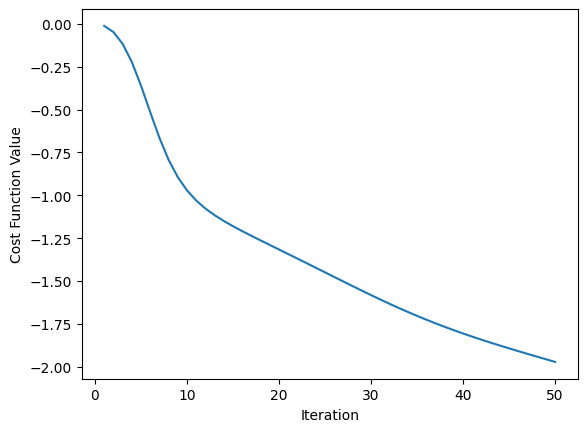

In [ ]:
n = 50
beta_1 = 0.0
delta_t = 0.03

dev_example = qml.device("default.qubit", wires=3) # Creates a device for the simulation
res_beta, res_energies = falqon(n, beta_1, delta_t, dev_example)

plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()

Y vamos a ver ahora cuáles son las probabilidades de observación de los posibles estados. Para ello, hay que ejecutar una vez todo el circuito cuántico (con sus $n$ capas) usando los $\beta$ calculados anteriormente.

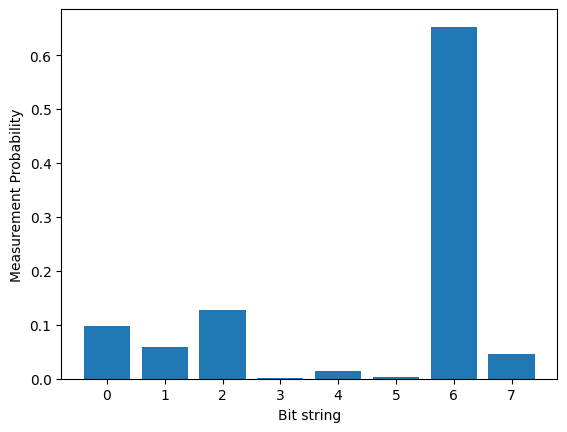

In [ ]:
@qml.qnode(dev_example, interface="autograd")
def prob_circuit():
    cost_h = cost_hamiltonian()
    driver_h = driver_hamiltonian()
    ansatz = build_ansatz(cost_h, driver_h, delta_t, dev_example.wires)
    ansatz(res_beta)
    return qml.probs(wires=dev_example.wires)

probs = prob_circuit()
plt.bar(range(2**len(dev_example.wires)), probs)
plt.xlabel("Bit string")
plt.ylabel("Measurement Probability")
plt.show()

Se ve que la solución más probable es $x = 110$, ¡que corresponde con el óptimo! Si hubiésemos querido aumentar su probabilidad de ser observado, podríamos haber aumentado el número de iteraciones para permitir que se alcance el estado de mínima energía.  

## 3. FALQON - C: FALQON con restricciones

Ya hemos visto cómo implementar con éxito el algoritmo FALQON tradicional; sin embargo, los problemas que puede resolver no contemplan restricciones de ningún tipo sobre las variables. Por ello, vamos a estudiar una variante del FALQON que sí que permite tenerlas en cuenta.

Siguiendo el mismo espíritu del FALQON, el algoritmo **FALQON-C** tiene como objetivo resolver problemas de optimización binaria **con restricciones** de forma eficiente en un computador cuántico. Mientras que FALQON está diseñado para problemas QUBO (sin restricciones), FALQON-C aborda directamente problemas de tipo **QCBO (Quadratic Constrained Binary Optimization)** sin necesidad de transformarlos en QUBO. Esto evita aumentar innecesariamente la profundidad del circuito cuántico.

La idea central es construir un nuevo operador **$L$** que combina la **función objetivo con penalizaciones** que elevan la energía de las soluciones no factibles. Así, el **estado de mínima energía de $L$** corresponde a la **mejor solución factible**.

### 3.1 Evolución cuántica y control

La evolución del sistema, al igual que antes, se basa en una versión discretizada de la ecuación de Schrödinger:

$$
|\psi_{k+1}\rangle = U_d(\beta_k) \, U_c \, |\psi_k\rangle,
$$

La novedad es que el control se calcula a partir de un nuevo **Hamiltoniano efectivo $L$** que incorpora las restricciones (antes era el propio Hamiltoniano de Coste el que realizaba el control). Para ello, establecemos el valor de $\beta_k$ así:

$$
\beta_{k+1} = -K \cdot f\left( \langle \psi_k | i [H_d, L] | \psi_k \rangle \right),
$$

donde $f(\cdot)$ es una función continua que satisface $x f(x) > 0$ para $x \ne 0$ (la mayoría de veces se suele coger $f(x) = x$ por simplificar el problema), y $K > 0$ es una constante que controla la intensidad del cambio en cada paso. Si $K$ es muy pequeño: el sistema evoluciona muy lentamente, la energía baja despacio, y puede requerir muchos pasos. Por otro lado, si $K$ es muy grande puede provocar oscilaciones o que el sistema sobrepase el estado deseado; en sistemas ruidosos o simuladores discretos, puede empeorar la convergencia o dificultar la implementación.


### 3.2 Construcción del operador $L$

Para que la evolución del sistema favorezca estados factibles, se construye el operador $L$ como:

$$
L := H_c + \sum_{j=1}^{k} \gamma_j H_p^{(j)},
$$

donde:

- $H_c$ es el Hamiltoniano que codifica la función objetivo,
- $H_p^{(j)}$ son Hamiltonianos de penalización asociados a las restricciones,
- $\gamma_j > 0$ son hiperparámetros que deben ser lo suficientemente grandes para penalizar efectivamente las soluciones no factibles. Si $\gamma_j$​ es muy pequeña, el sistema puede encontrar soluciones no factibles con menor energía que las factibles, por lo que habría una violación de restricciones. Por otro lado, si $\gamma_j​$ es muy grande, se garantiza que el estado de mínima energía sea factible. Pero el espectro de $L$ puede tener una gran dispersión, lo que afecta la dinámica. También puede dificultar la implementación del Hamiltoniano si se usan valores demasiado altos.

Sugerencia: si se conocen tanto la mejor solución factible y la total, elegir $\gamma_j$​ mayor que la diferencia de energía entre la mejor solución factible y la mejor solución total. Empíricamente, $\gamma_j∼1.5 · diferencia$ suele funcionar bien.

#### 3.2.1 Conversión de restricciones a penalizaciones

##### 1. Restricciones de igualdad $g(x) = 0$

Una restricción como:

$$
g(x) = x^T Q_g x + c_g^T x + a_g = 0
$$

se convierte en una penalización mediante el término:

$$
W(x) = (g(x))^2.
$$

Este valor será cero si la restricción se cumple, y estrictamente positivo en caso contrario. El Hamiltoniano de penalización correspondiente es:

$$
H_p = W(x) = (g(x))^2.
$$

##### 2. Restricciones de desigualdad $g(x) \leq 0$

Se reescriben como:

$$
g(x) \leq 0 \quad \Longleftrightarrow \quad \max(0, g(x))^2,
$$

pero para simplificar se suele tratar también como:

$$
W(x) = (g(x))^2,
$$

ya que cualquier valor positivo de $g(x)$ generará penalización.

**Consejo**: No impongas un $\gamma$ muy alto aquí (al menos no tan alto como en las restricciones de igualdad), porque puede ocurrir que una solución factible (cumple la restricción) quede lejos de la igualdad y sea duramente castigada.

En algunos problemas, si ocurre que no encuentras un parámetro adecuado para este tipo de restricciones, puedes penalizar poco la restricción y después eliminar o no considerar a mano aquellas soluciones que no cumplan la restricción, con la esperanza de que la o las primeras soluciones factibles sean de muy buena calidad.

### 3.3 Procedimiento

Los pasos para implementar el algoritmo FALQON-C son los siguientes:

1. Construir el Hamiltoniano de coste $H_c$ desde la función objetivo.

2. Construir los Hamiltonianos de penalización $H_p^{(j)}$ a partir de las restricciones.

3. Formar el operador total:

   $$
   L = H_c + \sum_j \gamma_j H_p^{(j)}.
   $$

4. Inicializar el estado cuántico:

   $$
   |\psi_0\rangle = |+\rangle^{\otimes n}.
   $$

5. Para cada paso $k = 1$ hasta la profundidad $n$:

   - Calcular:
     $$
     A_k = \langle \psi_k | i [H_d, L] | \psi_k \rangle,
     $$
   - Evaluar:
     $$
     \beta_{k+1} = -K \cdot f(A_k),
     $$
   - Evolucionar el estado:
     $$
     |\psi_{k+1}\rangle = U_d(\beta_k) U_c |\psi_k\rangle.
     $$

6. Al final, medir $|\psi_n\rangle$.

## 4. Ejemplo de Implementación del FALQON-C

Vamos a seguir con el ejemplo anterior, es decir, minimizar $f(x_0, x_1, x_2) = 2x_0 -4x_0x_1+3x_1x_2$ donde $x_i \in \{0, 1\}$. Y además, vamos a considerar 2 restricciones: $x_0+x_1-x_2 = 0$ y $x_0+2x_1-x_2 \leq 1$.

En primer lugar, vamos a definir el Hamiltoniano de Coste y el conductor, que coinciden con el anterior problema (Sección 2).

In [ ]:
def cost_hamiltonian_c():
    observables = [
        qml.PauliZ(1),
        qml.PauliZ(2),
        qml.PauliZ(0) @ qml.PauliZ(1),
        qml.PauliZ(1) @ qml.PauliZ(2)
    ]

    coeficientes = [
        1/4,   # Z1
        -3/4,  # Z2
        -1.0,  # Z0Z1
        3/4    # Z1Z2
    ]

    return qml.Hamiltonian(coeficientes, observables)

def driver_hamiltonian_c():
    return qml.Hamiltonian([1.0, 1.0, 1.0], [qml.X(0), qml.X(1), qml.X(2)])

En segundo lugar, tenemos que definir el operador $L$, que incluye el Hamiltoniano de Coste $H_c$ y los Hamiltonianos de Penalización por incumplimiento de las restricciones $H_{p_i}$. Calculemos los Hamiltonianos de Penalización.

En primer lugar, el de la igualdad, $x_0+x_1-x_2=0$. Definimos la penalización cuadrática como:

$$
P_{\text{eq}}(x) = (x_0 + x_1 - x_2)^2
$$

Sustituimos cada $ x_i $ por su forma en Pauli-Z:

$$
x_i = \frac{1 - Z_i}{2}
\quad \Rightarrow \quad
P_{\text{eq}} = \left( \frac{1 - Z_0}{2} + \frac{1 - Z_1}{2} - \frac{1 - Z_2}{2} \right)^2
$$

$$
= \left( \frac{2 - Z_0 - Z_1 - (1 - Z_2)}{2} \right)^2
= \left( \frac{1 - Z_0 - Z_1 + Z_2}{2} \right)^2
$$

$$
= \frac{1}{4} (1 - Z_0 - Z_1 + Z_2)^2
$$

Expandimos el cuadrado:

$$
= \frac{1}{4} \left( 1 + Z_0^2 + Z_1^2 + Z_2^2
- 2Z_0 - 2Z_1 + 2Z_2 + 2Z_0 Z_1 - 2Z_0 Z_2 - 2Z_1 Z_2 \right)
$$

Como $ Z_i^2 = I $, simplificamos:

$$
= \frac{1}{4} \left( 4 - 2Z_0 - 2Z_1 + 2Z_2 + 2Z_0 Z_1 - 2Z_0 Z_2 - 2Z_1 Z_2 \right)
$$

$$
= 1 - \frac{1}{2} Z_0 - \frac{1}{2} Z_1 + \frac{1}{2} Z_2
+ \frac{1}{2} Z_0 Z_1 - \frac{1}{2} Z_0 Z_2 - \frac{1}{2} Z_1 Z_2
$$

In [ ]:
def penalty_hamiltonian_eq():
    Z0 = qml.PauliZ(0)
    Z1 = qml.PauliZ(1)
    Z2 = qml.PauliZ(2)

    observables = [
        Z0,
        Z1,
        Z2,
        Z0 @ Z1,
        Z0 @ Z2,
        Z1 @ Z2,
    ]
    coeffs = [
        -0.5,    # -Z0
        -0.5,    # -Z1
        +0.5,    # +Z2
        +0.5,    # Z0 Z1
        -0.5,    # -Z0 Z2
        -0.5,    # -Z1 Z2
    ]

    return qml.Hamiltonian(coeffs, observables)

Vamos ahora con la restricción de desigualdad $x_0 + 2x_1 - x_2 \leq 1 $. Usamos una penalización cuadrática relajada:

$$
P_{\text{ineq}}(x) = \left( x_0 + 2x_1 - x_2 - 1 \right)^2
$$

Sustituyendo:

$$
= \left( \frac{1 - Z_0}{2} + 2 \cdot \frac{1 - Z_1}{2} - \frac{1 - Z_2}{2} - 1 \right)^2
$$

$$
= \left( \frac{1 - Z_0 + 2 - 2Z_1 - (1 - Z_2) - 2}{2} \right)^2
= \left( \frac{0 - Z_0 - 2Z_1 + Z_2}{2} \right)^2
$$

$$
= \frac{1}{4} ( -Z_0 - 2Z_1 + Z_2 )^2
$$

Expandimos el cuadrado y usamos $ Z_i^2 = I $ para obtener:

$$
= \frac{1}{4} \left( Z_0^2 + 4Z_1^2 + Z_2^2
+ 4Z_0 Z_1 - 2Z_0 Z_2 - 4Z_1 Z_2 \right)
$$

$$
= \frac{1}{4} (6 + 4 Z_0 Z_1 - 2 Z_0 Z_2 - 4 Z_1 Z_2)
= \frac{3}{2} I + Z_0 Z_1 - \frac{1}{2} Z_0 Z_2 - Z_1 Z_2
$$


In [ ]:
def penalty_hamiltonian_ineq():
    Z0 = qml.PauliZ(0)
    Z1 = qml.PauliZ(1)
    Z2 = qml.PauliZ(2)

    observables = [
        Z0 @ Z1,
        Z0 @ Z2,
        Z1 @ Z2,
    ]
    coeffs = [
        1,     # Z0 Z1
        -0.5,  # Z0 Z2
        -1.0,  # Z1 Z2
    ]

    return qml.Hamiltonian(coeffs, observables)

Ahora ya lo que queda es de nuevo muy parecido en todas las aplicaciones de FALQON-C. Hay que definir las siguientes funciones:
- En primer lugar, definimos una función `augmented_cost_hamiltonian` que corresponde con nuestro Hamiltoniano $L$, y que incorpora ya tanto el Hamiltoniano de coste (función objetivo) como los hamiltonianos de penalización. Para ello, tras llamar a las funciones que las crean, creamos otra vez una lista de coeficientes y operadores y los usamos para crear el Hamiltoniano.
- También definimos una función `commutator_hamiltonian` que calcula $i[H_d, L]$
- En tercer lugar, definimos una función `falqon_layer` que implementa la capa del coste y la de conducción.
- En cuarto lugar, definimos una función `build_ansatz` y `expval_circuit` que funcionan exactamente igual que las de FALQON
- En último lugar, definimos la función que implementa el algoritmo `falqon_c`, que funciona igual que en el caso original salvo porque ahora tenemos que tener en cuenta el Hamiltoniano de Conmutación, que es el que se utiliza para calcular el siguiente valor de $\beta$.  

In [ ]:
# L = H_c + γ1 H_p1 + γ2 H_p2
def augmented_cost_hamiltonian(gamma1, gamma2):
    Hc = cost_hamiltonian_c()
    Hp1 = penalty_hamiltonian_eq()
    Hp2 = penalty_hamiltonian_ineq()

    total_coeffs = list(Hc.coeffs) + list(gamma1 * np.array(Hp1.coeffs)) + list(gamma2 * np.array(Hp2.coeffs))
    total_ops = list(Hc.ops) + list(Hp1.ops) + list(Hp2.ops)

    return qml.Hamiltonian(total_coeffs, total_ops)

# Commutator i[Hm, L] para FALQON-C
def commutator_hamiltonian(Hm, L):
    comm = qml.commutator(Hm, L)
    return 1j * comm.simplify()

def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)

def build_ansatz(cost_h, driver_h, delta_t, wires):
    def ansatz(beta, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(falqon_layer, len(beta), beta, cost_h=cost_h, driver_h=driver_h, delta_t=delta_t)
    return ansatz

def expval_circuit(beta, measurement_h, cost_h, driver_h, delta_t, wires):
    ansatz = build_ansatz(cost_h, driver_h, delta_t, wires)
    ansatz(beta)
    return qml.expval(measurement_h)

def falqon_c(n, beta_1, delta_t, dev, gamma1, gamma2, k = 1):
    cost_h = augmented_cost_hamiltonian(gamma1, gamma2)
    driver_h = driver_hamiltonian_c()
    comm_h = commutator_hamiltonian(driver_h, cost_h)

    wires = dev.wires
    @qml.qnode(dev, interface="autograd")
    def circuit(beta, measurement_h):
        return expval_circuit(beta, measurement_h, cost_h, driver_h, delta_t, wires)

    beta = [beta_1]
    energies = []

    for _ in range(n):
        beta_next = -k * circuit(beta, measurement_h=comm_h)
        beta.append(beta_next)

        energy = circuit(beta, measurement_h=cost_h)
        energies.append(energy)

    return beta, energies

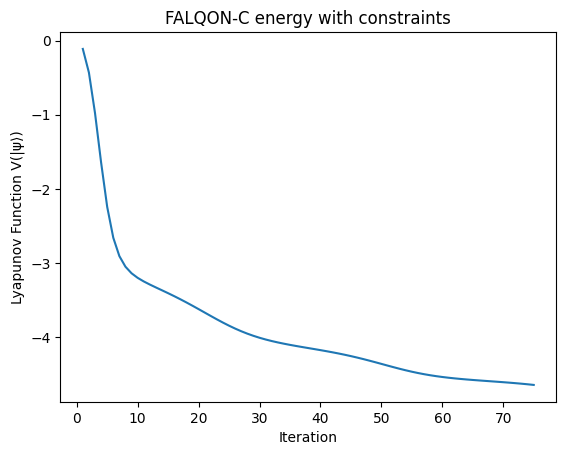

In [ ]:
# --- Simulación ---
n = 75
beta_1 = 0
delta_t = 0.01
gamma1 = 5
gamma2 = 1

dev = qml.device("default.qubit", wires=3)
res_beta, res_energies = falqon_c(n, beta_1, delta_t, dev, gamma1, gamma2)

# Gráfica de energía
plt.plot(range(1, n+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Lyapunov Function V(|ψ⟩)")
plt.title("FALQON-C energy with constraints")
plt.show()

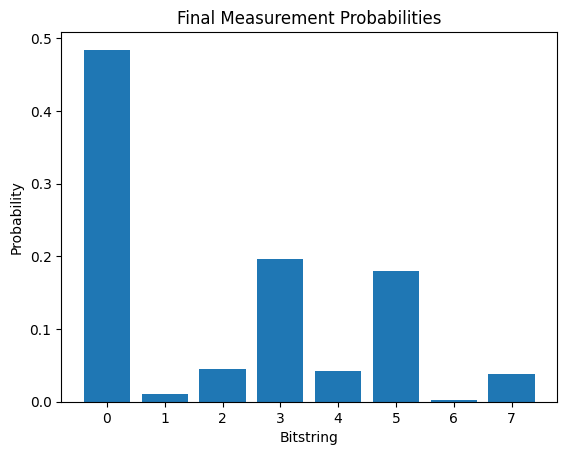

In [ ]:
# Probabilidades de medición
@qml.qnode(dev, interface="autograd")
def prob_circuit(res_beta, gamma1, gamma2):
    cost_h = augmented_cost_hamiltonian(gamma1, gamma2)
    driver_h = driver_hamiltonian_c()
    ansatz = build_ansatz(cost_h, driver_h, delta_t, dev.wires)
    ansatz(res_beta)
    return qml.probs(wires=dev.wires)

probs = prob_circuit(res_beta, gamma1, gamma2)
plt.bar(range(2**3), probs)
plt.xlabel("Bitstring")
plt.ylabel("Probability")
plt.title("Final Measurement Probabilities")
plt.show()

## FALQON - C : KNAPSACK PROBLEM

Ahora vamos a intentar resolver uno de los problemas de optimización combinatoria más famosos: *el problema de la mochila*.

¿Y cuál es el problema de la mochila? Imaginate que tienes una serie de objetos $x_i$ con $i = 1, ..., n$, los cuales tienen cada uno un determinado valor $v_i$ y un determinado peso $w_i$. Tienes una mochila de peso máximo $W$, y tu objetivo es maximizar el valor de los objetos que decidas llevar en la mochila sin pasarte del peso máximo.

Formulemos el problema matemáticamente. Nuestras variables son $x_i \in \{0, 1\} → \text{El objeto no se mete en la mochila o se mete}$, con $i = 1,...,n$, siendo $n$ el número de objetos. Cada objeto tiene asociados un valor $v_i$ y un peso $w_i$. Una constante importante a tener en cuenta es el peso máximo $W$.

Dado todo esto, la función a optimizar es

$$
max \ f(x_1,...x_n) = \sum_{i=1}^n x_i · v_i
$$

sujeto a la restricción

$$
\sum_{i=1}^n x_i · w_i \leq W → \sum_{i=1}^n x_i · w_i - W \leq 0
$$

Vamos a calcular el Hamiltoniano de coste y el de penalización haciendo la conversión al mundo cuántico $x_i = \frac{1-Z_i}{2}$.

En primer lugar, el Hamiltoniano de Coste resulta ser:

$$
\sum_{i=1}^n x_i · v_i = \sum_{i=1}^n \frac{1-Z_i}{2} v_i = \sum_{i=1}^n \frac{1}{2} v_i - \sum_{i=1}^n \frac{1}{2}v_i · Z_i
$$

Pero sólo implementamos el segundo término porque el primero es una constante

In [ ]:
def cost_hamiltonian_knapsack():
    coeffs = []
    observables = []
    for i, v in enumerate(values):
        coeffs.append(-v / 2)
        observables.append(qml.PauliZ(i))
    return qml.Hamiltonian(coeffs, observables)

Vamos ahora con el Hamiltoniano de penalización

$$
\sum_{i=1}^n x_i · w_i - W \leq 0 → (\sum_{i=1}^n x_i · w_i - W)^2 → (\sum_{i=1}^n x_i · w_i)^2 + W^2 -2W \sum_{i=1}^n x_i w_i
$$

Ignoramos la constante y expandimos el sumatorio al cuadrado

$$
\sum_i \sum_j x_ix_jw_iw_j -2W \sum_i x_iw_i
$$

Pasando a $Z_i$

$$
\sum_i \sum_j (\frac{1-Z_i}{2})(\frac{1-Z_j}{2})w_iw_j - 2W \sum_i (\frac{1-Z_i}{2})w_i = \sum_i \sum_j \frac{1-Z_i-Z_j+Z_iZ_j}{4}w_iw_j - W \sum_i w_i +W \sum_i Z_iw_i
$$

$$
= \sum_i \sum_j \frac{1}{4}w_iw_j - \sum_i\sum_j \frac{w_iw_j}{4}Z_i - \sum_i\sum_j \frac{w_iw_j}{4}Z_j + \sum_i\sum_j \frac{w_iw_j}{4}Z_iZ_j - W \sum_i w_i+W \sum_i Z_iw_i
$$

Hacemos desaparecer los dos términos constantes (el primero y el quinto) el segundo y el tercero se pueden sumar. Además, $\sum_j w_j = W$

$$
-W \sum_i \frac{w_i}{2}Z_i + \sum_i\sum_j \frac{w_iw_j}{4}Z_iZ_j +W \sum_i Z_iw_i
$$

Además, el primer y el tercer término se pueden juntar:

$$
\sum_i\sum_j \frac{w_iw_j}{4}Z_iZ_j  -\frac{W}{2} \sum_i w_iZ_i
$$

A la hora de implementar el código, hay que tener en cuenta los casos $Z_iZ_i = I$, que no los añadimos.

In [ ]:
def penalty_hamiltonian_ineq_knapsack():
    coeffs = []
    observables = []

    # Construcción de (∑ w_i x_i - C)^2
    # x_i ↦ (1 - Z_i)/2
    Z = [qml.PauliZ(i) for i in range(n_qubits)]
    const = -capacity
    expr = [(wi, Zi) for wi, Zi in zip(weights, Z)]

    # (∑ w_i x_i - C)^2 = expr^2
    for i in range(n_qubits):
        for j in range(n_qubits):
            wij = weights[i] * weights[j]
            obs = Z[i] @ Z[j] if i != j # else qml.Identity(i) # Z_i Z_j y Z_i^2 = I
            coeff = wij / 4 if i != j
            observables.append(obs)
            coeffs.append(coeff)

    for i in range(n_qubits):
        wi = weights[i]
        observables.append(Z[i])
        coeffs.append(-wi * const / 2)

    return qml.Hamiltonian(coeffs, observables)

El resto del código es prácticamente igual a las otras implementaciones de FALQON - C

In [ ]:
def driver_hamiltonian_knapsack(n):
    return qml.Hamiltonian([1.0] * n, [qml.PauliX(i) for i in range(n)])

def commutator_hamiltonian_knapsack(Hm, L):
    return (1j * qml.commutator(Hm, L)).simplify()

def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)

def build_ansatz(cost_h, driver_h, delta_t, wires):
    def ansatz(beta, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(falqon_layer, len(beta), beta, cost_h=cost_h, driver_h=driver_h, delta_t=delta_t)
    return ansatz

def expval_circuit(beta, measurement_h, cost_h, driver_h, delta_t, wires):
    ansatz = build_ansatz(cost_h, driver_h, delta_t, wires)
    ansatz(beta)
    return qml.expval(measurement_h)

def augmented_cost_hamiltonian_knapsack(gamma):
    Hc = cost_hamiltonian_knapsack()
    Hp = penalty_hamiltonian_ineq_knapsack()

    total_coeffs = list(Hc.coeffs) + list(gamma * np.array(Hp.coeffs))
    total_ops = list(Hc.ops) + list(Hp.ops)
    return qml.Hamiltonian(total_coeffs, total_ops)

def falqon_c(n_steps, beta_1, delta_t, dev, gamma, k):
    L = augmented_cost_hamiltonian_knapsack(gamma)
    driver_h = driver_hamiltonian_knapsack(len(dev.wires))
    comm_h = commutator_hamiltonian_knapsack(driver_h, L)
    wires = dev.wires

    @qml.qnode(dev, interface="autograd")
    def circuit(beta, measurement_h):
        return expval_circuit(beta, measurement_h, L, driver_h, delta_t, wires)

    beta = [beta_1]
    energies = []

    # Diagnóstico: energía inicial
    init_E = circuit([beta_1], measurement_h=L)
    print(f"Initial energy: {init_E:.4f}")

    for _ in range(n_steps):
        beta_next = -k * circuit(beta, measurement_h=comm_h)
        beta.append(beta_next)

        energy = circuit(beta, measurement_h=L)
        energies.append(energy)

    return beta, energies, L, driver_h

Initial energy: 15.5556


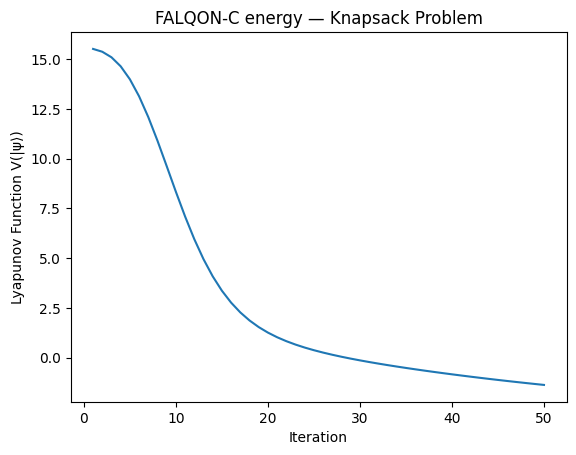

In [ ]:
# Datos del problema de la mochila
""" # n = 3

values = [5, 3, 4]
weights = [2, 1, 3]
capacity = 3
"""

""" n = 4
values = [6, 2, 5, 8]
weights = [3, 1, 2, 4]
capacity = 6
n_qubits = len(values)

# Parámetros para conseguir bajada de energía errática pero óptimo en la práctica
n_steps = 50
beta_1 = 0.0
delta_t = 0.005
gamma = 10
k = 1

# Parámetros para conseguir bajada de energía correcta y óptimo tras eliminar infactibles
n_steps = 50
beta_1 = 0.0
delta_t = 0.005
gamma = 1
k = 1
"""

""" n = 5
values = [6, 2, 5, 8, 10]
weights = [3, 1, 2, 4, 5]
capacity = 9
n_qubits = len(values)

# Parámetros para conseguir bajada de energía correcta y óptimo tras eliminar infactibles
n_steps = 100
beta_1 = 0.0
delta_t = 0.001
gamma = 10
k = 0.5
"""

"""# n = 6
values = [6, 2, 5, 8, 10, 12]
weights = [3, 1, 2, 4, 5, 6]
capacity = 10
n_qubits = len(values)

# Parámetros para conseguir bajada de energía correcta y óptimo tras eliminar infactibles
n_steps = 100
beta_1 = 0.0
delta_t = 0.001
gamma = 2.5
k = 0.5
"""

n = 7
values = [2, 5, 6, 8, 10, 12, 15]
weights = [1, 2, 3, 4, 5, 6, 7]
capacity = 13
n_qubits = len(values)

n_steps = 50
beta_1 = 0.0
delta_t = 0.001
gamma = 0.5/0.75/1/1.5
k = 1

"""
# n = 7
values = [2, 5, 6, 8, 10, 12, 15]
weights = [1, 2, 3, 4, 5, 6, 7]
capacity = 13
n_qubits = len(values)

# Parámetros para conseguir bajada de energía correcta y que las primeras soluciones factibles sean todas buenas (una óptima es la 2ª)
n_steps = 100
beta_1 = 0.0
delta_t = 0.001
gamma = 0.95
k = 0.5

# Parámetros para conseguir bajada de energía correcta y que las primeras soluciones factibles sean todas buenas (óptimas las 3ª y 4ª)
n_steps = 100
beta_1 = 0.0
delta_t = 0.001
gamma = 0.95
k = 0.6

# Parámetros para conseguir bajada de energía correcta, que todas las infactibles vayan primero, y después las factibles (todas las primeras factibles son buenas soluciones)
n_steps = 50
beta_1 = 0.0
delta_t = 0.001
gamma = 0.5/0.75/1/1.5
k = 1
"""
"""
# n = 10
values = [2, 5, 6, 8, 10, 12, 15, 17, 18, 20]
weights = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
capacity = 28
n_qubits = len(values)

n_steps = 50
beta_1 = 0.0
delta_t = 0.001
gamma = 0.75
k = 1
"""

dev = qml.device("default.qubit", wires=n_qubits)

res_beta, res_energies, L, Hm = falqon_c(n_steps, beta_1, delta_t, dev, gamma, k)

plt.plot(range(1, n_steps+1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Lyapunov Function V(|ψ⟩)")
plt.title("FALQON-C energy — Knapsack Problem")
plt.show()

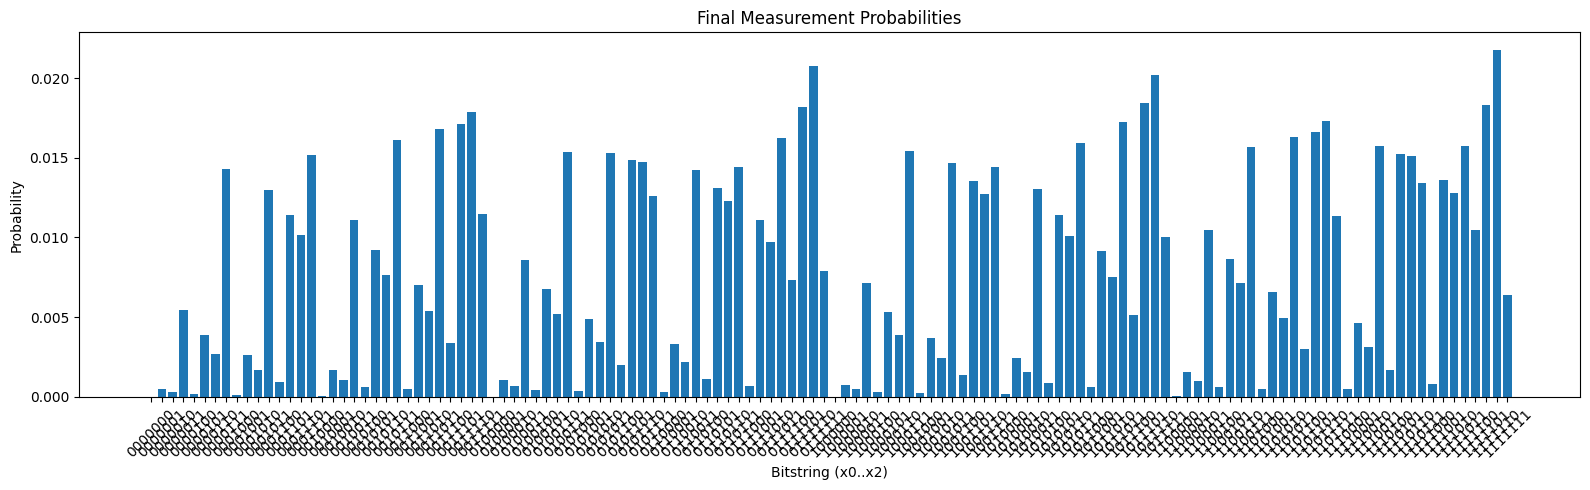

In [ ]:
# === Medir probabilidades ===
@qml.qnode(dev, interface="autograd")
def prob_circuit(res_beta, gamma):
    L = augmented_cost_hamiltonian_knapsack(gamma)
    driver_h = driver_hamiltonian_knapsack(len(dev.wires))
    ansatz = build_ansatz(L, driver_h, delta_t, dev.wires)
    ansatz(res_beta)
    return qml.probs(wires=dev.wires)

probs = prob_circuit(res_beta, gamma)
bitstrings = [format(i, f"0{n_qubits}b") for i in range(2**n_qubits)]
plt.figure(figsize=(16, 5))  # Mucho más ancha
plt.bar(bitstrings, probs)
plt.xticks(rotation=45)
plt.xlabel("Bitstring (x0..x2)")
plt.ylabel("Probability")
plt.title("Final Measurement Probabilities")
plt.tight_layout()
plt.show()

 Bitstring   Prob.   Peso   Valor   Factible
   1111110   0.022     21      43          ❌
   0111110   0.021     20      41          ❌
   1011110   0.020     19      38          ❌
   1011101   0.018     20      41          ❌
   1111101   0.018     22      46          ❌
   0111101   0.018     21      44          ❌
   0011110   0.018     18      36          ❌
   1101110   0.017     18      37          ❌
   1011011   0.017     21      43          ❌
   0011101   0.017     19      39          ❌
   0011011   0.017     20      41          ❌
   1101101   0.017     19      40          ❌
   1101011   0.016     20      42          ❌
   0111011   0.016     22      46          ❌
   0010111   0.016     21      43          ❌
   1010111   0.016     22      45          ❌
   1110011   0.016     19      40          ❌
   1111011   0.016     23      48          ❌
   1100111   0.016     21      44          ❌
   1000111   0.015     19      39          ❌
   0100111   0.015     20      42          ❌
   0101011

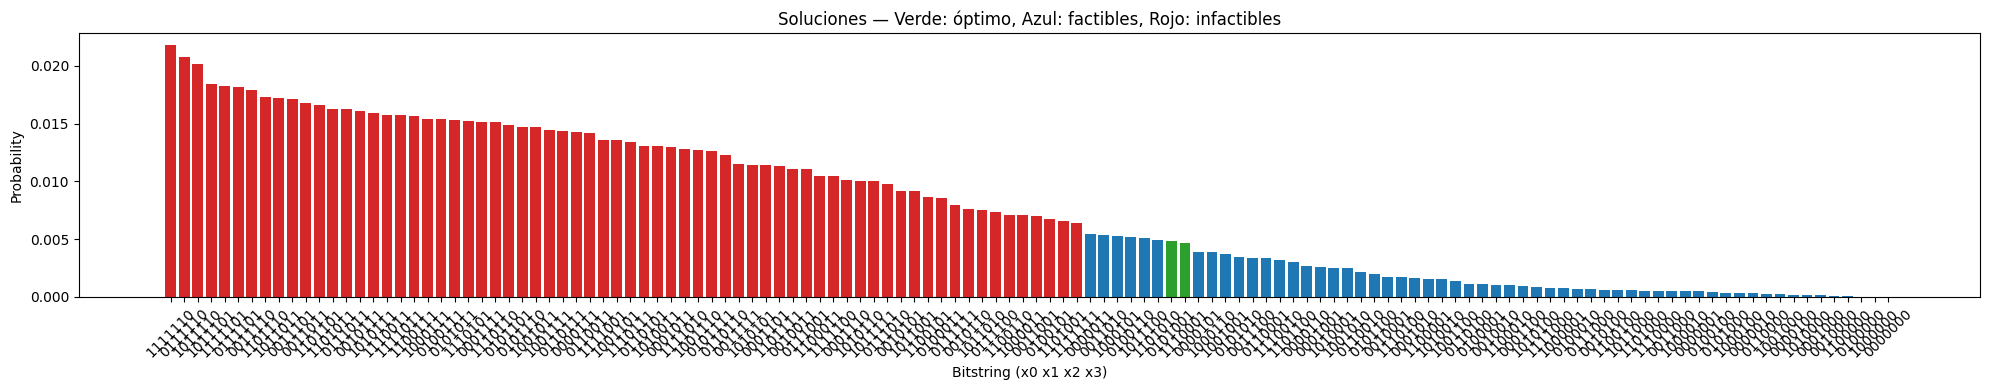

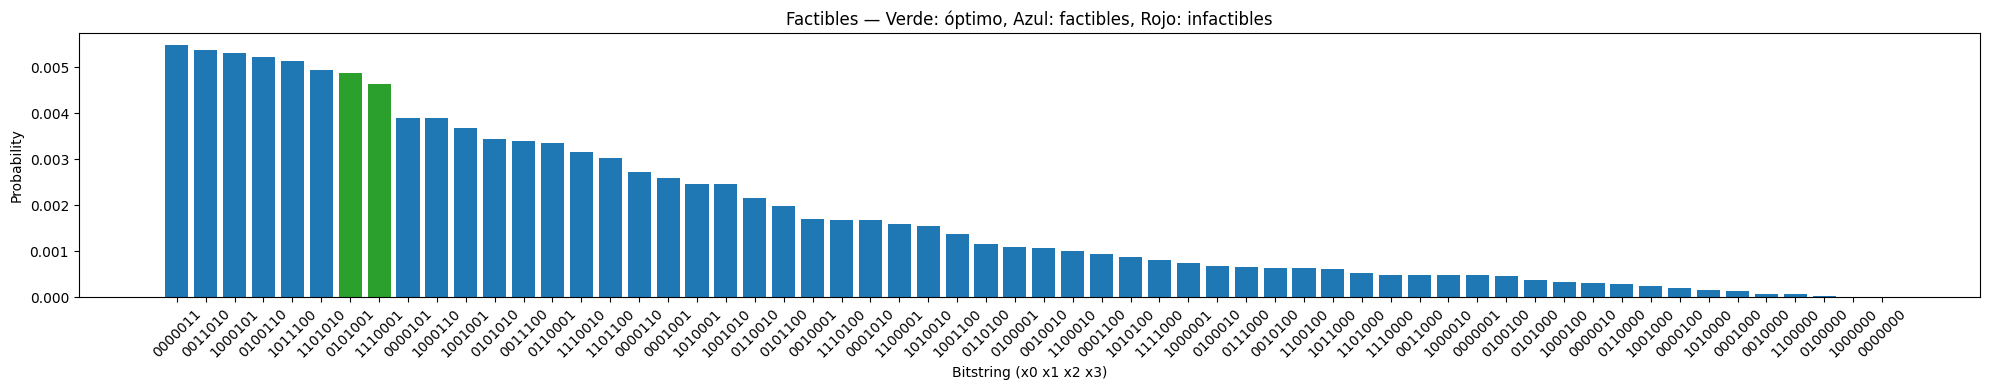

In [ ]:
def analizar_resultados_knapsack(probs, values, weights, capacity, show_all, n_best):
    n = len(values)
    bitstrings = [format(i, f"0{n_qubits}b") for i in range(2**n_qubits)]

    resultados = []
    for b, p in zip(bitstrings, probs):
        x = [int(bit) for bit in b]
        peso = sum(w * xi for w, xi in zip(weights, x))
        valor = sum(v * xi for v, xi in zip(values, x))
        factible = peso <= capacity
        resultados.append((b, p, peso, valor, factible))

    # Ordenar por probabilidad descendente
    resultados.sort(key=lambda r: r[1], reverse=True)

    print(f"{'Bitstring':>10}  {'Prob.':>6}  {'Peso':>5}  {'Valor':>6}  {'Factible':>9}")
    num_shown = 0
    for b, p, peso, valor, fact in resultados:
        f = "✅" if fact else "❌"
        if show_all:
            print(f"{b:>10}  {p:6.3f}  {peso:5}  {valor:6}  {f:>9}")
        elif not show_all and num_shown < n_best and fact:
            print(f"{b:>10}  {p:6.3f}  {peso:5}  {valor:6}  {f:>9}")
            num_shown += 1

    # Encontrar mejor valor factible
    mejores = [r for r in resultados if r[4]]
    if mejores:
        mejor_valor = max(mejores, key=lambda r: r[3])[3]
    else:
        mejor_valor = None

    # Para hacer gráfica con solo factibles
    solo_factibles = [r for r in resultados if r[-1] == True]
    if not show_all:
        solo_factibles = solo_factibles[:n_best]

    if show_all:
        # Gráfica con colores
        colores = []
        for b, p, peso, valor, fact in resultados:
            if fact and valor == mejor_valor:
                colores.append("tab:green")
            elif fact:
                colores.append("tab:blue")
            else:
                colores.append("tab:red")

        etiquetas = [r[0] for r in resultados]
        alturas = [r[1] for r in resultados]

        plt.figure(figsize=(20, 4))
        plt.bar(etiquetas, alturas, color=colores)
        plt.xticks(rotation=45)
        plt.xlabel("Bitstring (x0 x1 x2 x3)")
        plt.ylabel("Probability")
        plt.title("Soluciones — Verde: óptimo, Azul: factibles, Rojo: infactibles")
        plt.tight_layout()
        plt.show()

    # Gráfica con colores
    colores = []
    for b, p, peso, valor, fact in solo_factibles:
        if fact and valor == mejor_valor:
            colores.append("tab:green")
        elif fact:
            colores.append("tab:blue")
        else:
            colores.append("tab:red")

    # Ahora de solo las factibles
    etiquetas = [r[0] for r in solo_factibles]
    alturas = [r[1] for r in solo_factibles]

    plt.figure(figsize=(20, 4))
    plt.bar(etiquetas, alturas, color=colores)
    plt.xticks(rotation=45)
    plt.xlabel("Bitstring (x0 x1 x2 x3)")
    plt.ylabel("Probability")
    plt.title("Factibles — Verde: óptimo, Azul: factibles, Rojo: infactibles")
    plt.tight_layout()
    plt.show()

n_best = 10

show_all = True

analizar_resultados_knapsack(probs, values, weights, capacity, show_all, n_best)

## Ejemplo Max Clique

Aquí se presenta un último ejemplo con un problema de grafos: el objetivo es dado un grafo, con sus vértices y aristas, encontrar el subgrafo más grande donde se conectan todos los vértices entre sí.

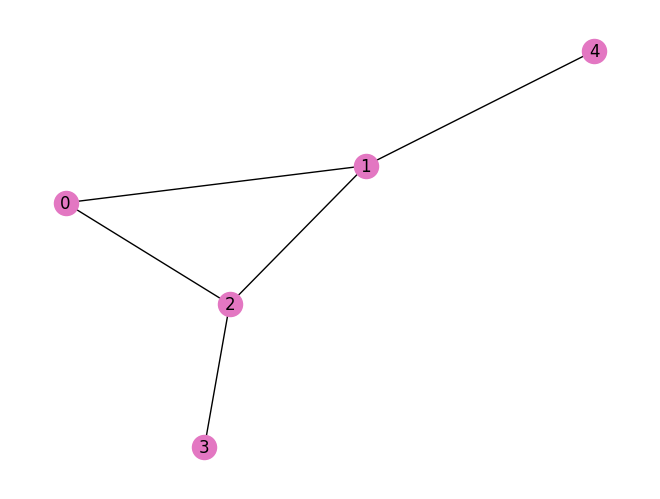

In [5]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)]
graph = nx.Graph(edges)
positions = nx.spring_layout(graph, seed=1)
nx.draw(graph, with_labels=True, node_color="#e377c2", pos=positions)
plt.show()

In [6]:
cost_h, driver_h = qaoa.max_clique(graph, constrained=False)

print("Cost Hamiltonian")
print(cost_h)
print("Driver Hamiltonian")
print(driver_h)

Cost Hamiltonian
0.75 * (Z(0) @ Z(3)) + -0.75 * Z(0) + -0.75 * Z(3) + 0.75 * (Z(0) @ Z(4)) + -0.75 * Z(0) + -0.75 * Z(4) + 0.75 * (Z(1) @ Z(3)) + -0.75 * Z(1) + -0.75 * Z(3) + 0.75 * (Z(2) @ Z(4)) + -0.75 * Z(2) + -0.75 * Z(4) + 0.75 * (Z(3) @ Z(4)) + -0.75 * Z(3) + -0.75 * Z(4) + 1.0 * Z(0) + 1.0 * Z(1) + 1.0 * Z(2) + 1.0 * Z(3) + 1.0 * Z(4)
Driver Hamiltonian
1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3) + 1 * X(4)


In [9]:
def build_hamiltonian(graph):
    H = qml.Hamiltonian([], [])

    # Computes the complement of the graph
    graph_c = nx.complement(graph)

    for k in graph_c.nodes:
        # Adds the terms in the first sum
        for edge in graph_c.edges:
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) @ qml.PauliZ(j) - qml.PauliY(k))
            if k == j:
                H += 6 * (qml.PauliZ(i) @ qml.PauliY(k) - qml.PauliY(k))
        # Adds the terms in the second sum
        H += 6 * qml.PauliY(k)

    return H

print("MaxClique Commutator")
print(build_hamiltonian(graph))

MaxClique Commutator
1.0 * 6 * (Y(0) @ Z(3) + -1 * Y(0)) + 1.0 * 6 * (Y(0) @ Z(4) + -1 * Y(0)) + 1.0 * 6 * Y(0) + 1.0 * 6 * (Y(1) @ Z(3) + -1 * Y(1)) + 1.0 * 6 * Y(1) + 1.0 * 6 * (Y(2) @ Z(4) + -1 * Y(2)) + 1.0 * 6 * Y(2) + 1.0 * 6 * (Z(0) @ Y(3) + -1 * Y(3)) + 1.0 * 6 * (Z(1) @ Y(3) + -1 * Y(3)) + 1.0 * 6 * (Y(3) @ Z(4) + -1 * Y(3)) + 1.0 * 6 * Y(3) + 1.0 * 6 * (Z(0) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * (Z(2) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * (Z(3) @ Y(4) + -1 * Y(4)) + 1.0 * 6 * Y(4)


In [10]:
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, delta_t * beta_k, 1)

In [11]:
def build_maxclique_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        layers = len(beta)
        for w in dev.wires:
            qml.Hadamard(wires=w)
        qml.layer(
            falqon_layer,
            layers,
            beta,
            cost_h=cost_h,
            driver_h=driver_h,
            delta_t=delta_t
        )

    return ansatz


def expval_circuit(beta, measurement_h):
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

In [12]:
def max_clique_falqon(graph, n, beta_1, delta_t, dev):
    comm_h = build_hamiltonian(graph) # Builds the commutator
    cost_h, driver_h = qaoa.max_clique(graph, constrained=False) # Builds H_c and H_d
    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd") # The ansatz + measurement circuit is executable

    beta = [beta_1] # Records each value of beta_k
    energies = [] # Records the value of the cost function at each step

    for i in range(n):
        # Adds a value of beta to the list and evaluates the cost function
        beta.append(-1 * cost_fn(beta, measurement_h=comm_h))  # this call measures the expectation of the commuter hamiltonian
        energy = cost_fn(beta, measurement_h=cost_h)  # this call measures the expectation of the cost hamiltonian
        energies.append(energy)

    return beta, energies

In [13]:
n = 40
beta_1 = 0.0
delta_t = 0.03

dev = qml.device("default.qubit", wires=graph.nodes) # Creates a device for the simulation
res_beta, res_energies = max_clique_falqon(graph, n, beta_1, delta_t, dev)

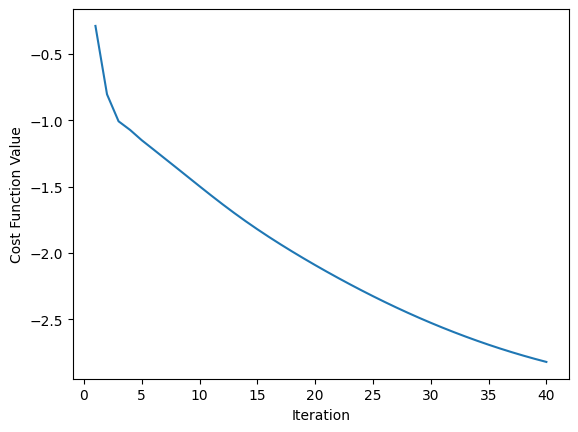

In [14]:
plt.plot(range(n+1)[1:], res_energies)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.show()

In [15]:
@qml.qnode(dev, interface="autograd")
def prob_circuit():
    ansatz = build_maxclique_ansatz(cost_h, driver_h, delta_t)
    ansatz(res_beta)
    return qml.probs(wires=dev.wires)

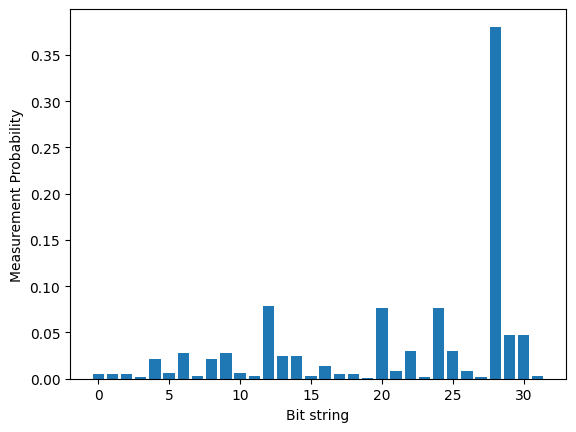

In [16]:
probs = prob_circuit()
plt.bar(range(2**len(dev.wires)), probs)
plt.xlabel("Bit string")
plt.ylabel("Measurement Probability")
plt.show()

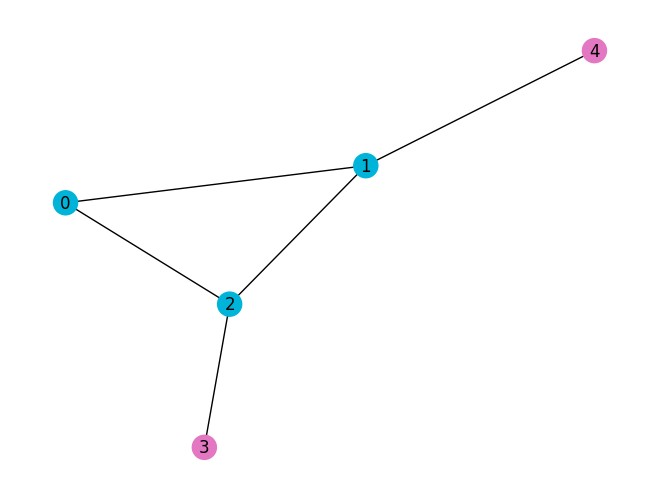

In [17]:
graph = nx.Graph(edges)
cmap = ["#00b4d9"]*3 + ["#e377c2"]*2
positions = nx.spring_layout(graph, seed=1)
nx.draw(graph, with_labels=True, node_color=cmap, pos=positions)
plt.show()